In [61]:
import pandas as pd
import matplotlib.pyplot  as plt

In [63]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(url, delimiter=';')

In [64]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [66]:
print(data.isnull().sum())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


In [67]:
X = data.drop(columns=['quality'])
y = data['quality']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [69]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [70]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import numpy as np


In [71]:
base_models = [
    RandomForestClassifier(n_estimators=100, random_state=42),
    GradientBoostingClassifier(n_estimators=100, random_state=42),
    SVC(probability=True, random_state=42)
]

In [74]:
meta_model = LogisticRegression()

In [83]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
meta_features = np.zeros((X_train.shape[0], len(base_models)))
meta_test_features = np.zeros((X_test.shape[0], len(base_models)))

In [84]:
y_train = y_train.values

for train_index, val_index in kf.split(X_train):
    X_t, X_val = X_train[train_index], X_train[val_index]
    y_t, y_val = y_train[train_index], y_train[val_index]
    
    for i, model in enumerate(base_models):
        model.fit(X_t, y_t)
        meta_features[val_index, i] = model.predict_proba(X_val)[:, 1]
        meta_test_features[:, i] += model.predict_proba(X_test)[:, 1] / kf.n_splits


In [86]:
meta_model.fit(meta_features, y_train)

LogisticRegression()

In [87]:
final_predictions = meta_model.predict(meta_test_features)

In [88]:
X_train_blend, X_blend, y_train_blend, y_blend = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

In [89]:
for model in base_models:
    model.fit(X_train_blend, y_train_blend)

In [90]:
meta_features_blend = np.column_stack([model.predict_proba(X_blend)[:, 1] for model in base_models])
meta_test_features_blend = np.column_stack([model.predict_proba(X_test)[:, 1] for model in base_models])


In [91]:
meta_model_blend = LogisticRegression()
meta_model_blend.fit(meta_features_blend, y_blend)

LogisticRegression()

In [92]:
final_predictions_blend = meta_model_blend.predict(meta_test_features_blend)

In [93]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [94]:
accuracy_stacking = accuracy_score(y_test, final_predictions)
precision_stacking = precision_score(y_test, final_predictions, average='weighted')
recall_stacking = recall_score(y_test, final_predictions, average='weighted')
f1_stacking = f1_score(y_test, final_predictions, average='weighted')

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [95]:
print(f'Stacking Accuracy: {accuracy_stacking}')
print(f'Stacking Precision: {precision_stacking}')
print(f'Stacking Recall: {recall_stacking}')
print(f'Stacking F1-Score: {f1_stacking}')


Stacking Accuracy: 0.5270833333333333
Stacking Precision: 0.4414920747018204
Stacking Recall: 0.5270833333333333
Stacking F1-Score: 0.44976993865030673


In [96]:
accuracy_blending = accuracy_score(y_test, final_predictions_blend)
precision_blending = precision_score(y_test, final_predictions_blend, average='weighted')
recall_blending = recall_score(y_test, final_predictions_blend, average='weighted')
f1_blending = f1_score(y_test, final_predictions_blend, average='weighted')

C:\Users\HP\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [97]:
print(f'Blending Accuracy: {accuracy_blending}')
print(f'Blending Precision: {precision_blending}')
print(f'Blending Recall: {recall_blending}')
print(f'Blending F1-Score: {f1_blending}')

Blending Accuracy: 0.40625
Blending Precision: 0.1650390625
Blending Recall: 0.40625
Blending F1-Score: 0.2347222222222222


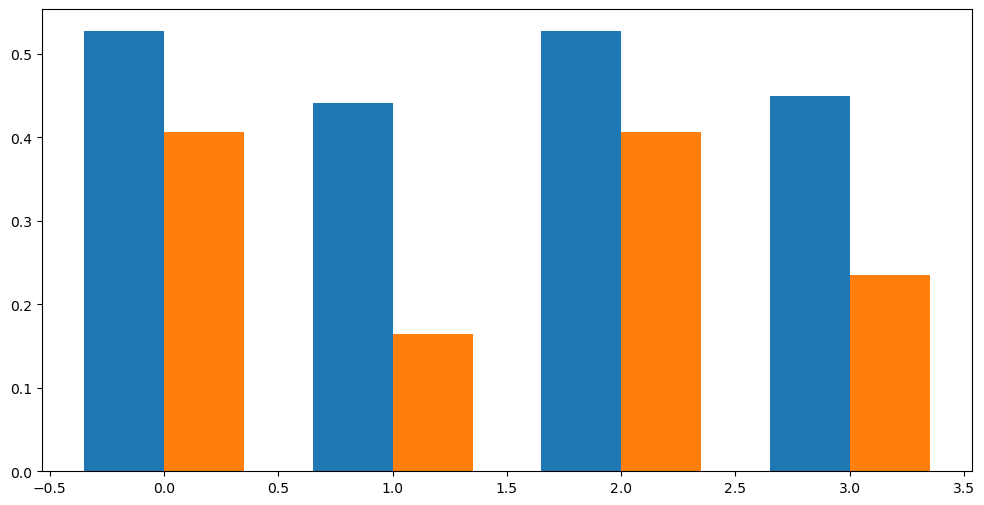

In [98]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
stacking_scores = [accuracy_stacking, precision_stacking, recall_stacking, f1_stacking]
blending_scores = [accuracy_blending, precision_blending, recall_blending, f1_blending]

x = np.arange(len(metrics))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, stacking_scores, width, label='Stacking')
rects2 = ax.bar(x + width/2, blending_scores, width, label='Blending')